In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPooling2D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib

DEV_MODE = False
data_root_path = pathlib.Path("../input")

In [2]:
# will feed through data set map
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [32, 32])
    
    image /= 255.0  # normalize to [0,1] range
    return image

In [3]:
# augmentations will feed through training data set
def random_bright(image):
    return tf.image.random_brightness(image, 0.12)
            
def random_contrast(image):
    return tf.image.random_contrast(image, 0.9, 1.1)

def augment_image(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = random_contrast(image)
    image = random_bright(image)
    return image,label

In [6]:
# read training csv
train_df = pd.read_csv(data_root_path/'train.csv', dtype={'id': 'str', 'has_cactus': np.int32})
DATASET_SIZE = len(train_df)
print("n =", DATASET_SIZE)

n = 17500


In [7]:
# fix distribution in training data since there are more 1's than 0's
# if there are 75% 1's then by guessing 1 we are already at 75% accuracy
no_cactus, yes_cactus = train_df.has_cactus.value_counts().sort_values().values
no_multiplier = int(yes_cactus/no_cactus)-1
no_cactus_rows = train_df[train_df.has_cactus == 0]
for i in range(no_multiplier):
    train_df = train_df.append(no_cactus_rows)

In [14]:
ROOT_TRAIN_PATH = '../input/train/train/'
train_paths = ROOT_TRAIN_PATH + train_df['id']

In [15]:
# Dataset
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
image_ds = path_ds.map(load_and_preprocess_image)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_df['has_cactus'].values, tf.int32))

In [16]:
IMAGE_SHAPE = (32, 32, 3)

# batching
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds)).shuffle(DATASET_SIZE)

BATCH_SIZE = 16

if DEV_MODE:
    train_size, val_size = int(0.7 * DATASET_SIZE), int(0.3 * DATASET_SIZE)
else:
    train_size, val_size = DATASET_SIZE, 0

train_ds = image_label_ds.map(augment_image).take(train_size).batch(BATCH_SIZE).repeat()
val_ds = image_label_ds.skip(train_size).batch(BATCH_SIZE).repeat()

In [17]:
def get_model():
    model = Sequential()
    
    model.add(Conv2D(32, (2, 2),  input_shape=IMAGE_SHAPE,  activation='relu'))
    model.add(Conv2D(64, (3, 3),  activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (4, 4),  activation='relu'))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

model = get_model()

model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 31, 31, 32)        416       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 128)       131200    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 64)          204864    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
__________

In [19]:
# lets training re-augment images multiple times per epoch
train_steps = 2*(train_size//BATCH_SIZE)
val_steps = val_size//BATCH_SIZE

if val_steps == 0:
    val_steps = None
    val_ds = None

history = model.fit(train_ds,
                    steps_per_epoch=train_steps, 
                    epochs=50,
                    validation_data=val_ds, 
                    validation_steps=val_steps,
                    callbacks=None)

2186/2186 [==============================] - 37s 17ms/step - loss: 0.1338 - acc: 0.9475


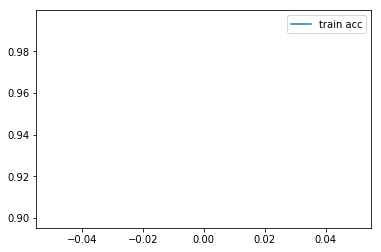

In [20]:
#plot accuracy
plt.plot(history.history['acc'], label="train acc")
if DEV_MODE:
    plt.plot(history.history['val_acc'], label="val acc")
plt.legend()
plt.show()

In [21]:
#evaluate on non augmented images, should not be worse
training_eval = tf.data.Dataset.zip((image_ds, label_ds)).shuffle(DATASET_SIZE)
training_eval = training_eval.take(DATASET_SIZE).batch(DATASET_SIZE)
model.evaluate(training_eval, steps=1)

1/1 [==============================] - 10s 10s/step - loss: 0.0734 - acc: 0.9736


[0.07337398082017899, 0.9736]

In [24]:
#test dataset setup
test_paths = [path for path in sorted(pathlib.Path('../input/test/test/').glob('*.jpg'))]
TEST_SIZE = len(test_paths)
test_path_ds = tf.data.Dataset.from_tensor_slices([str(path)for path in test_paths])
test_image_ds = test_path_ds.map(load_and_preprocess_image)
test_image_ds = test_image_ds.take(TEST_SIZE).batch(TEST_SIZE)

In [25]:
#predictions
preds=model.predict(test_image_ds, steps = 1)

In [26]:
#write submission csv
test_df=pd.DataFrame({'id': [path.name for path in test_paths] })
test_df['has_cactus']=preds
test_df.to_csv("submission.csv",index=False)